# Sweeps in 1000 genomes male X haplotypes

In [51]:
import os, sys, math, re
from pathlib import Path
import numpy
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

numpy.random.seed(7)

Import variables global to the entire analysis:

In [52]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [53]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

from hg19_chrom_sizes import hg19_chrom_sizes

Plotting setup:

In [54]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Ignore warnings:

In [55]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

### Load data

In [56]:

df_list = list()

for chrom in ['X', '2']:
    for tup in ag.g1000_pop_info.itertuples():
        dir_path = ag.steps_dir / '1000genomes' / 'male_dist_admix_masked_stores' / chrom / tup.population
        for path in dir_path.glob('sweep_data_*.hdf'):
            dist_cut, clade_cut = map(float, re.search(r'sweep_data_([^_]+)_([^_]+)%.hdf', path.name).groups())
            clade_cut /= 100
            df = pd.read_hdf(path)
            df['dist_cut'] = dist_cut
            df['clade_cut'] = clade_cut
            df['chrom'] = chrom
            df['population'] = tup.population
            df['superpop'] = tup.superpop
            df_list.append(df)
    
sweep_data = pd.concat(df_list)

sweep_data['superpop'] = pd.Categorical(sweep_data.superpop, 
                                        categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'], 
                                        ordered=True)
sweep_data.head()


indiv_1   start     end  mean_dist  mean_dist_af  prop_indivs_missing  \
0  HG02461       0  100000        NaN           NaN                  1.0   
1  HG02461  100000  200000        NaN           NaN                  1.0   
2  HG02461  200000  300000        NaN           NaN                  1.0   
3  HG02461  300000  400000        NaN           NaN                  1.0   
4  HG02461  400000  500000        NaN           NaN                  1.0   

   win_swept  win_swept_af  called  called_af    ...     run_length  swept  \
0      False         False   False      False    ...             22  False   
1      False         False   False      False    ...             22  False   
2      False         False   False      False    ...             22  False   
3      False         False   False      False    ...             22  False   
4      False         False   False      False    ...             22  False   

   run_id_af  run_length_af  swept_af  dist_cut  clade_cut  chrom  population  \
0          1             22     False   0.00005        0.3      X         GWD   
1          1             22     False   0.00005        0.3      X         GWD   
2          1             22     False   0.00005        0.3      X         GWD   
3          1             22     False   0.00005        0.3      X         GWD   
4          1             22     False   0.00005        0.3      X         GWD   

   superpop  
0       AFR  
1       AFR  
2       AFR  
3       AFR  
4       AFR  

[5 rows x 25 columns]

In [57]:
np.fmod(sweep_data.clade_cut.unique(), 0.1)

array([ 0.1 ,  0.05,  0.05,  0.1 ,  0.02,  0.09,  0.05,  0.06,  0.06,
        0.03,  0.08,  0.1 ,  0.06,  0.06,  0.03,  0.07,  0.03,  0.08,
        0.02,  0.06,  0.05,  0.03,  0.05,  0.02,  0.09,  0.08,  0.08,
        0.07,  0.06,  0.01,  0.09,  0.  ,  0.  ,  0.05,  0.04,  0.06,
        0.03,  0.  ,  0.1 ,  0.04,  0.09,  0.03,  0.08,  0.08,  0.01,
        0.03,  0.07,  0.05,  0.03,  0.04,  0.07,  0.02,  0.1 ,  0.01,
        0.06,  0.02,  0.01,  0.01,  0.04,  0.04,  0.09,  0.03,  0.07,
        0.07,  0.02,  0.04,  0.06,  0.  ,  0.08,  0.05,  0.09,  0.09,
        0.04,  0.01,  0.03,  0.07,  0.04,  0.01,  0.04,  0.06,  0.02,
        0.05,  0.07,  0.08,  0.05,  0.04,  0.07,  0.02,  0.01,  0.08,
        0.09,  0.09,  0.02,  0.01,  0.07,  0.08,  0.01,  0.  ,  0.09,  0.02])

In [58]:
subset_df = sweep_data.loc[(sweep_data.dist_cut == 5e-5) & (sweep_data.chrom == 'X') & (sweep_data.population == 'CHB')]

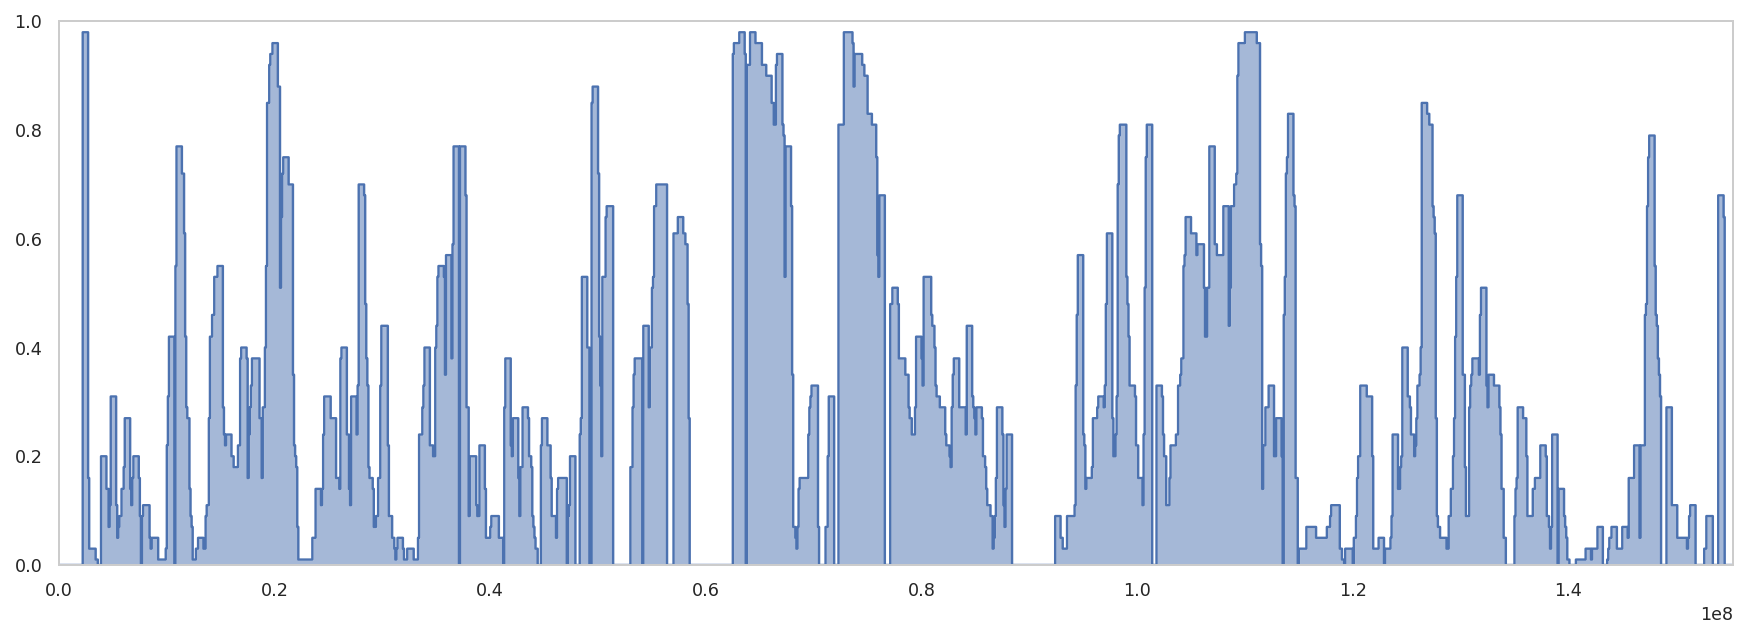

In [59]:
def filter_func(grp):

    cols = ['chrom', 'population', 'start', 'end', 'clade_cut']
    
    df = grp.loc[grp.swept == True]
    if not len(df):
        return grp.loc[grp.clade_cut == grp.clade_cut.min(), cols].iloc[0]
    return df.loc[df.clade_cut == df.clade_cut.max(), cols].iloc[0]

test_df = subset_df.groupby(['chrom', 'population', 'start']).apply(filter_func).reset_index(drop=True)


with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
    
    df = stairs(test_df)
    ax.plot(df.pos, df.clade_cut)
    ax.fill_between(df.pos, df.clade_cut, alpha=0.5)



... shows the proportion of individuals that across 500kb has a mutual distance below cutoff.

In [60]:
plot_df = (subset_df
           .groupby(['chrom', 'clade_cut', 'start', 'end', 'superpop', 'population'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(prop_swept=lambda df: df.nr_swept / df.total)
          )
plot_df.head()

chrom  clade_cut   start     end superpop population  nr_swept  total  \
0     X        0.0       0  100000      EAS        CHB       0.0     46   
1     X        0.0  100000  200000      EAS        CHB       0.0     46   
2     X        0.0  200000  300000      EAS        CHB       0.0     46   
3     X        0.0  300000  400000      EAS        CHB       0.0     46   
4     X        0.0  400000  500000      EAS        CHB       0.0     46   

   prop_swept  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

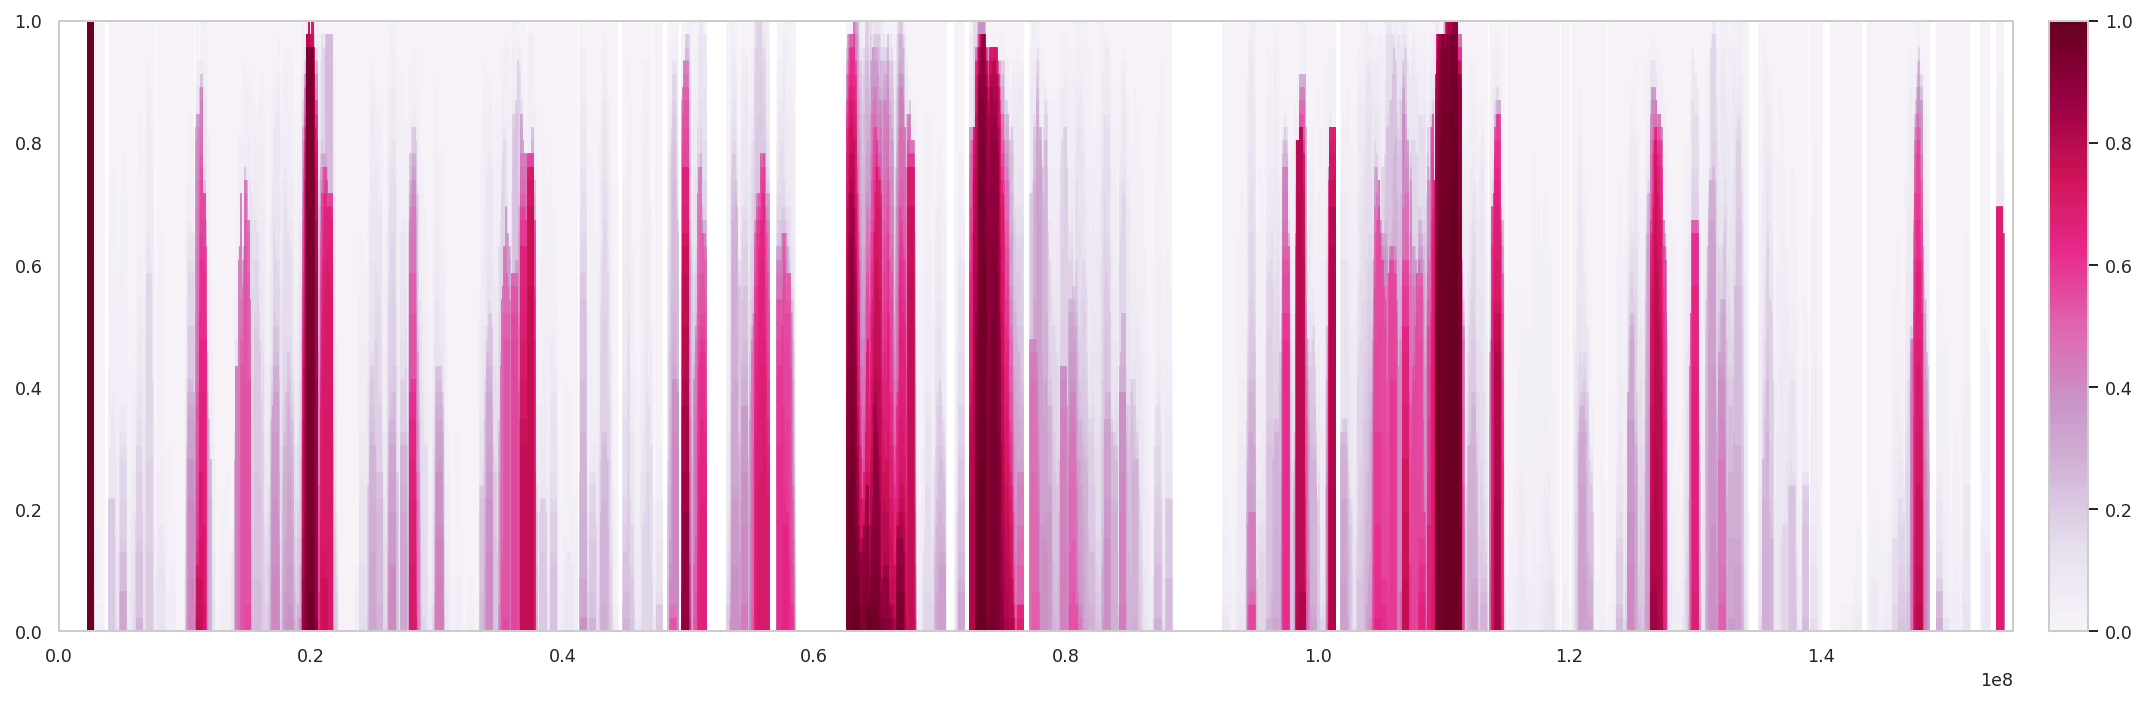

In [61]:
colormap = matplotlib.cm.get_cmap('PuRd', 100)

n_subplots = sweep_data.clade_cut.unique().size

from mpl_toolkits.axes_grid1 import make_axes_locatable


with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
#     ax.set_facecolor('black')
    
    for clade_cut, call_df in plot_df.groupby('clade_cut'):
        
#         if clade_cut < 0.5:
#             continue

        df = stairs(call_df)
        ax.fill_between(df.pos, df.prop_swept, color=colormap(clade_cut), linewidth=0.0)

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="2%", pad=0.25)    
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=colormap, orientation='vertical')
    plt.gcf().add_axes(ax_cb)

    plt.tight_layout()



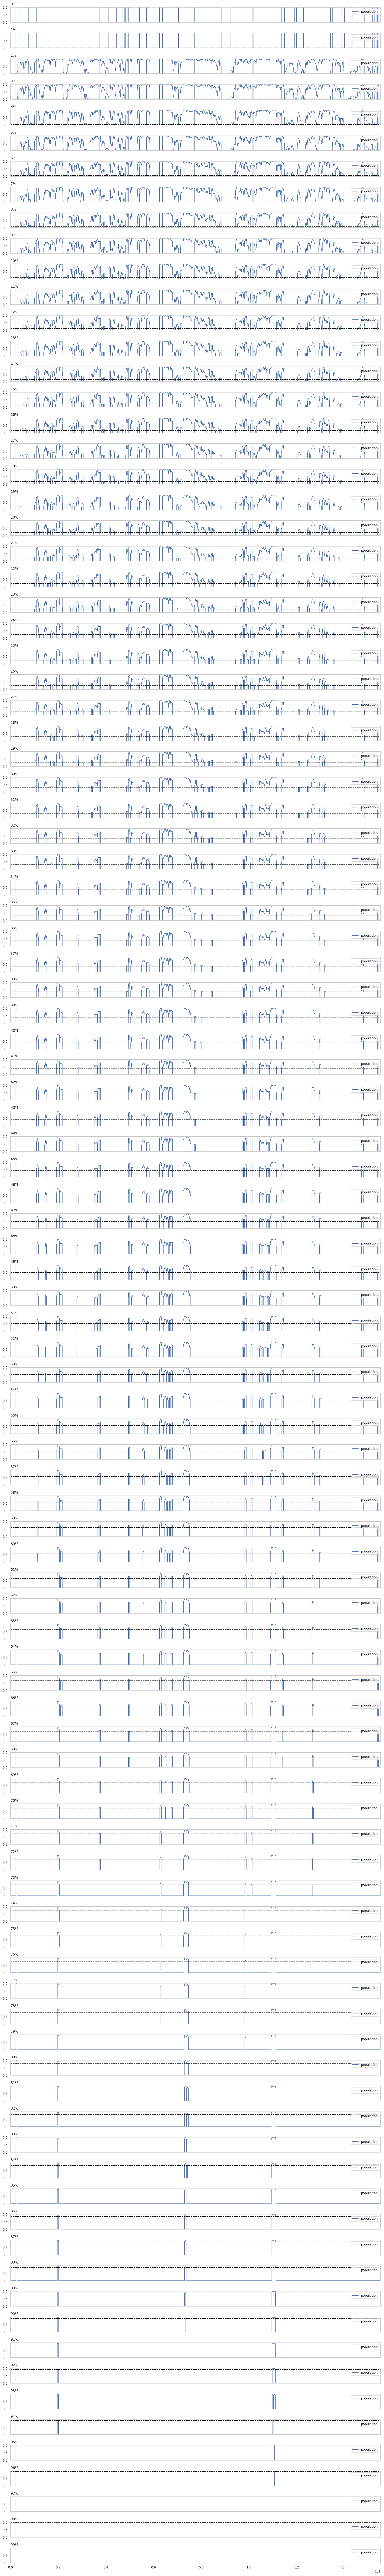

In [62]:
n_subplots = sweep_data.clade_cut.unique().size

with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, axes = plt.subplots(n_subplots, 1, sharey=True, sharex=True, figsize=(15, 100),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})

    for ax, (clade_cut, call_df) in zip(axes, plot_df.groupby('clade_cut')):
        
        ax.set_title("{:.0f}%".format(clade_cut*100), loc='left', fontsize=10)

        df = call_df.copy()
        df.loc[df.prop_swept < clade_cut, 'prop_swept'] = 0

        df = stairs(df)
        ax.plot(df.pos, df.prop_swept, label='population')
        ax.legend(loc='upper right')

        ax.axhline(clade_cut, color='black', linestyle='dashed')
        
    plt.tight_layout()


In [6]:
df_list = list()
for chrom in ['X']:
    for tup in ag.g1000_pop_info.itertuples():
        df = pd.read_hdf(ag.steps_dir / '1000genomes' / \
                'male_dist_admix_masked_stores' / chrom / tup.population / 'sweep_data_5e-05_30%.hdf')
        df['chrom'] = chrom
        df['population'] = tup.population
        df['superpop'] = tup.superpop
        df_list.append(df)
    
sweep_data = pd.concat(df_list)

sweep_data['superpop'] = pd.Categorical(sweep_data.superpop, 
                                        categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'], 
                                        ordered=True)
sweep_data.head()

SyntaxError: invalid syntax (<ipython-input-6-27b887e330f7>, line 16)

# Mask for missing data and PARs and add columns such as never_swept...

In [88]:
ag.g1000_pop_info.style.set_properties(**{'text-align': 'left'})

## Missing regions

## Stats on sweeps

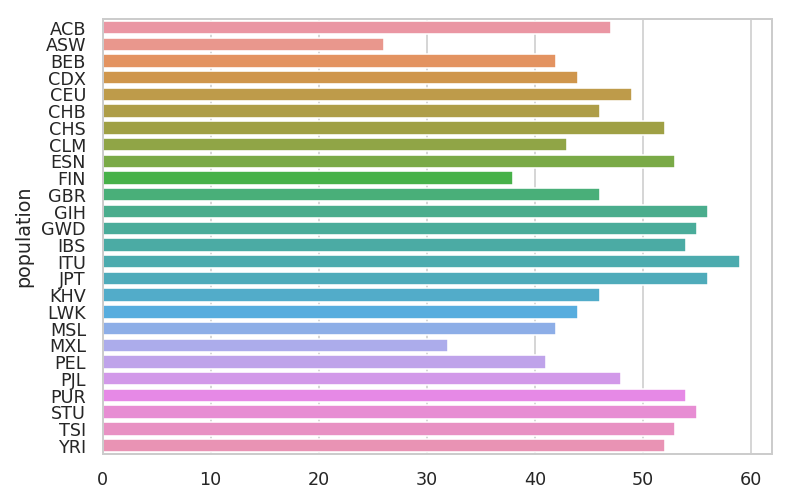

In [18]:
sr = sweep_data.groupby('population').apply(lambda df: df.indiv_1.unique().size)
sns.barplot(sr, sr.index)


## Proportion swept

In [34]:
# group by start, end, region and compute size
plot_df = (sweep_data
           .groupby(['start', 'end', 'superpop', 'population'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(prop_swept=lambda df: df.nr_swept / df.total)
          )
plot_df.head()

start     end superpop population  nr_swept  total  prop_swept
0      0  100000      AFR        ACB       0.0     47         0.0
1      0  100000      AFR        ASW       0.0     26         0.0
2      0  100000      AFR        ESN       0.0     53         0.0
3      0  100000      AFR        GWD       0.0     55         0.0
4      0  100000      AFR        LWK       0.0     44         0.0

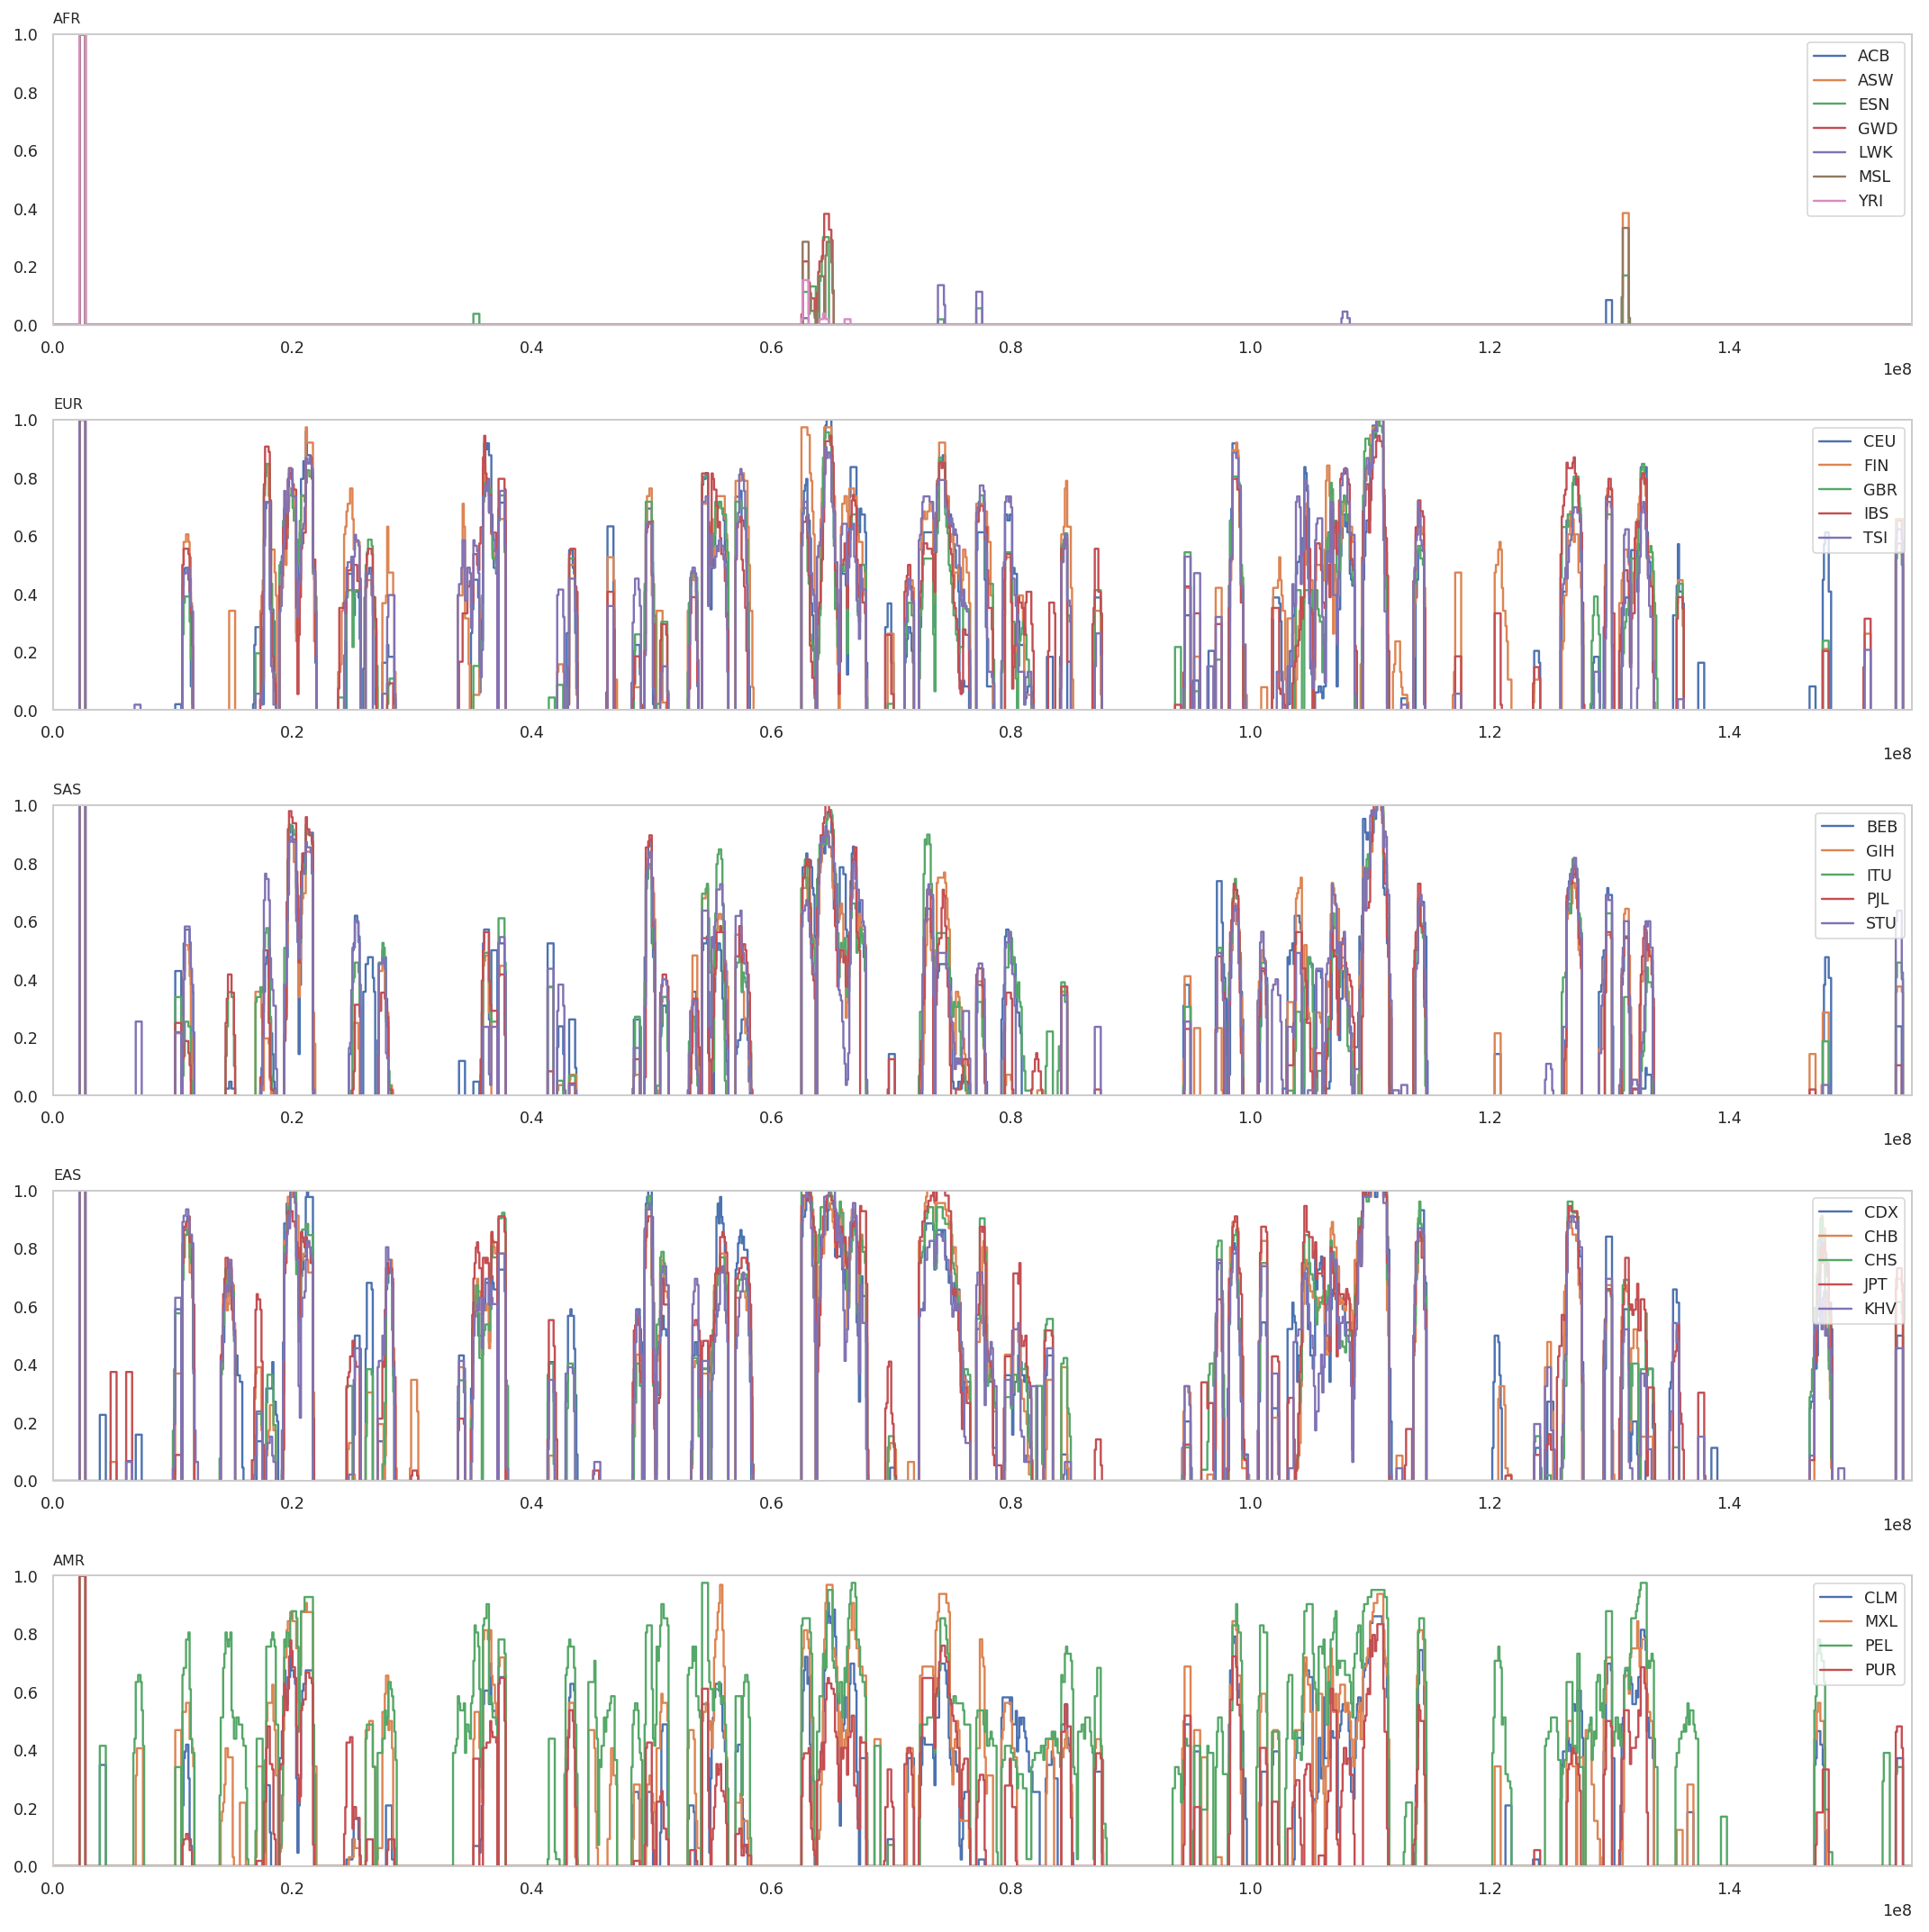

In [90]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(5, 1, sharey=True, figsize=(15, 15),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})

    for ax, (superpop, super_df) in zip(axes, plot_df.groupby('superpop')):
        ax.set_title(superpop, loc='left', fontsize=8)

        for (population, pop_df) in super_df.groupby('population'):
            df = stairs(pop_df)
            ax.plot(df.pos, df.prop_swept, label=population)
        ax.legend(loc='upper right')

    plt.tight_layout()
plt.savefig(str(ag.figures_dir / "g1000_ech.pdf"))

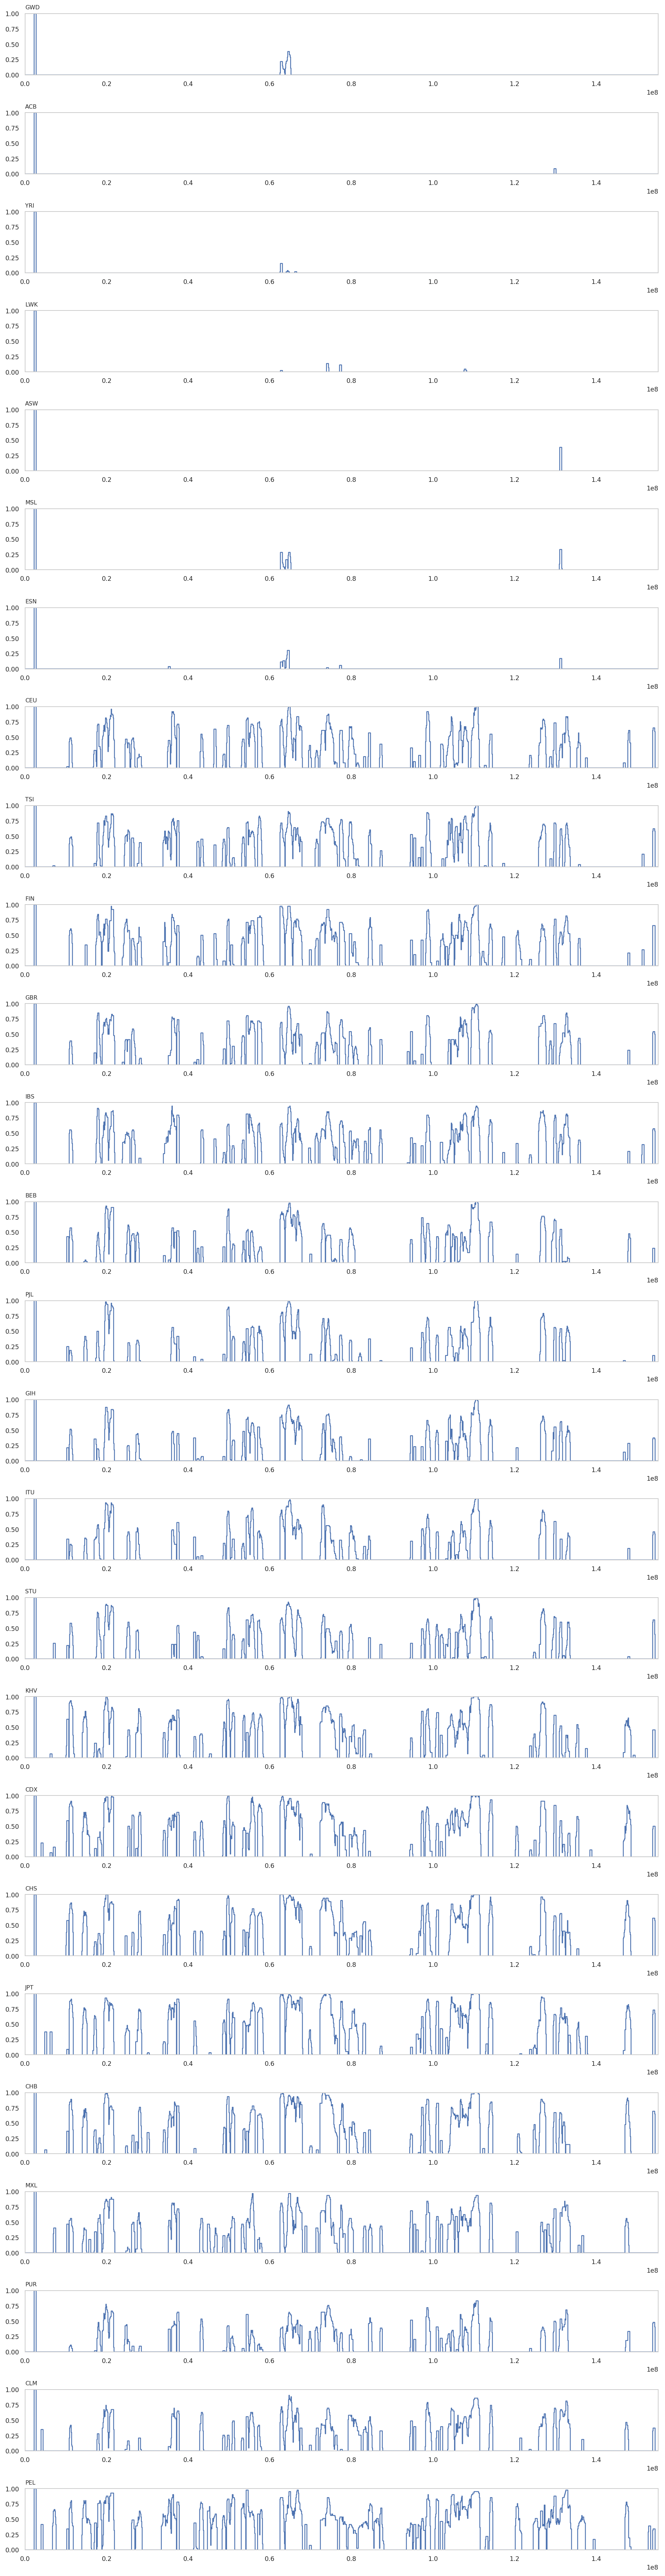

In [33]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(26, 1, sharey=True, figsize=(13, 50),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
    for ax, population in zip(axes, ag.g1000_pop_info.population):
        df = stairs(plot_df.loc[plot_df.population == population])
        ax.plot(df.pos, df.prop_swept)
        ax.set_title(population, loc='left', fontsize=8)
    plt.tight_layout()

    

In [ ]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(26, 1, sharex=True, sharey=True, figsize=(10, 10),                         
                             subplot_kw={'xlim':(0, chromosome_lengths['X']),
                                         'ylim':(0, 1)})

    for ax, population in zip(axes, g1000_populations):
        df = plot_df.loc[plot_df.population == population]    
        
        for tup in df.itertuples():
            if tup.nr_swept:
                g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, tup.nr_swept/tup.total, 
#                                  facecolor=region_colors[reg], 
                                 linewidth=0,
                                 #edgecolor=None,#region_colors[reg], 
                                 zorder=2))
        ax.set_title(reg, loc='left')
                
        for tup in missing_regions.loc[missing_regions.is_missing == True].itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                     facecolor='lightgray', 
                     linewidth=0,
#                     edgecolor=None,
                     alpha=0.5,
                     zorder=1))
    #     ax.set_ylim(0, df.nr_swept.max())

    plt.tight_layout()
    
    plt.savefig(str(figures_dir / "tot_swept_by_region.pdf"))
    #plt.close() # closing teh plot suppres automatic plotting without plt.show()